### SI figure notebook for exploring count thresholding of MERFISH data for UMAPs

In [8]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import anndata as ad
import scanpy as sc
import string
import seaborn as sns
import h5py
import math
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,12])
    plt.rc('svg', fonttype='none')

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    #sc.pp.scale(ad) # Scale each gene to unit variance

In [6]:
# Define the path of the analyzed MERFISH data
dataPathPost = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults'

# Define the experiment
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021',
                      'MsKidney_CellBoundary_VZG116_111921']
prefixCountsFilter = 'FilteredCounts'
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

# Load the MERlin results
VizgenCountsFilter = []
QCFilter = []

for i in range(len(experimentName)):
    # Filtered counts per segmented cell
    VizgenCountsFilter.append(ad.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

    # Get filtering criteria
    QCFilter.append(VizgenCountsFilter[i].uns['QC_filter'])
    
# Save liver and kidney experiments separately
liver_ind = 0
kidney_ind = 1

VizgenLiver = VizgenCountsFilter[liver_ind]
VizgenKidney = VizgenCountsFilter[kidney_ind]

print('Data loaded.')

Data loaded.


In [9]:
# Make a list of Anndata objects that filter out increasing numbers of cells.
N_filter_liver = [20,40,60,80,100,120]
N_filter_kidney = [30,60,90,120,150,180]

VizgenLiver_list = [VizgenLiver.copy() for i in range(len(N_filter_liver))]
VizgenKidney_list = [VizgenKidney.copy() for i in range(len(N_filter_kidney))]

# Preprocess the Anndata objects
for i in tqdm(range(len(N_filter_liver))):
    preprocess_ad(VizgenLiver_list[i], N_filter_liver[i])
    sc.tl.pca(VizgenLiver_list[i])
    sc.pp.neighbors(VizgenLiver_list[i])
    sc.tl.umap(VizgenLiver_list[i])
    sc.tl.leiden(VizgenLiver_list[i])
    
for i in tqdm(range(len(N_filter_kidney))):
    preprocess_ad(VizgenKidney_list[i], N_filter_kidney[i])
    sc.tl.pca(VizgenKidney_list[i])
    sc.pp.neighbors(VizgenKidney_list[i])
    sc.tl.umap(VizgenKidney_list[i])
    sc.tl.leiden(VizgenKidney_list[i])
    
print('scanpy analysis complete.')

100%|█████████████████████████████████████████████| 6/6 [07:39<00:00, 76.60s/it]

scanpy analysis complete.


### Plot figure

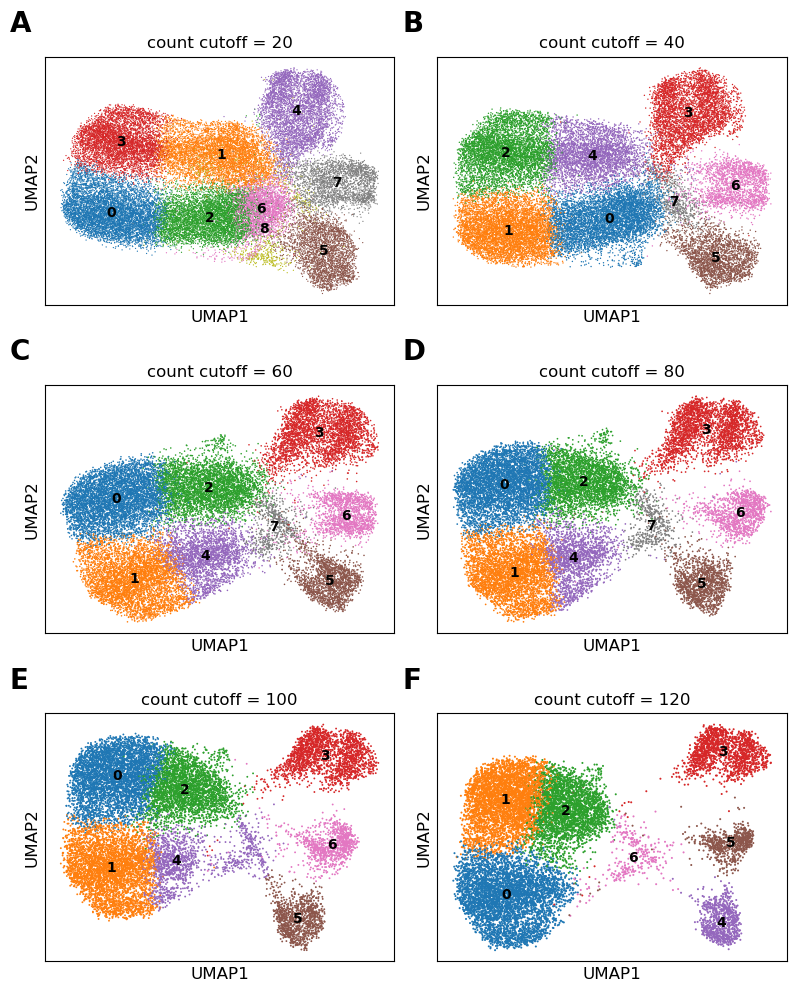

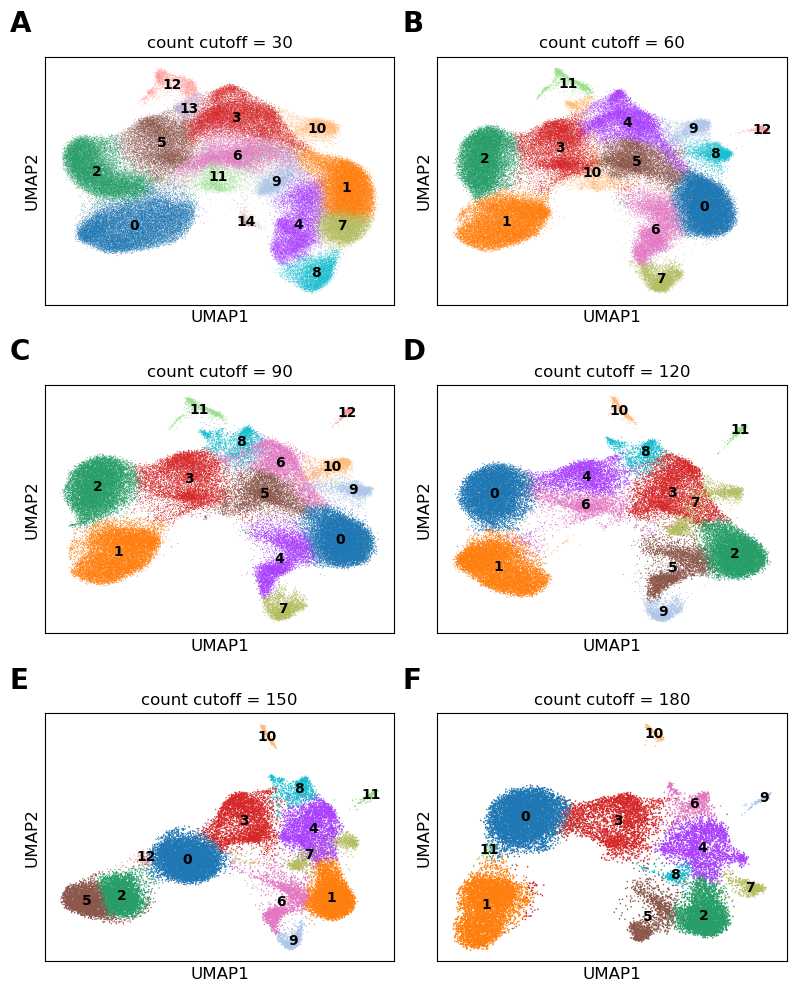

In [17]:
set_plotting_style()

# Plot the liver figure
fig1, axes = plt.subplots(3, 2, figsize=(8,10))

for i, ax in zip(range(len(N_filter_liver)), axes.flatten()):
    sc.pl.umap(VizgenLiver_list[i], color='leiden', ax=ax, legend_loc='on data',
              title='count cutoff = ' + str(N_filter_liver[i]), show=False)
    
# Label subpanels
axes_label = [axes[0,0], axes[0,1], axes[1,0], axes[1,1],
              axes[2,0], axes[2,1]]
for n, ax in enumerate(axes_label):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

fig1.tight_layout()
plt.show()

# Plot the kidney figure
fig2, axes = plt.subplots(3, 2, figsize=(8,10))
for i, ax in zip(range(len(N_filter_kidney)), axes.flatten()):
    sc.pl.umap(VizgenKidney_list[i], color='leiden', ax=ax, legend_loc='on data',
              title='count cutoff = ' + str(N_filter_kidney[i]), show=False)
    
# Label subpanels
axes_label = [axes[0,0], axes[0,1], axes[1,0], axes[1,1],
              axes[2,0], axes[2,1]]
for n, ax in enumerate(axes_label):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
                 
fig2.tight_layout()                 
plt.show()

In [18]:
# Export figures
fig1.savefig('../../figures/SIFig_UMAP_count_thresholds_liver.pdf')
fig1.savefig('../../figures/SIFig_UMAP_count_thresholds_liver.png')

fig2.savefig('../../figures/SIFig_UMAP_count_thresholds_kidney.pdf')
fig2.savefig('../../figures/SIFig_UMAP_count_thresholds_kidney.png')

print('Figures saved.')

Figures saved.
